
## Tutorial - Fine-tuning a Resnet for Multi-label Classification


#### Author: Antonio Rueda-Toicen
#### [AI Service Center @ Hasso Plattner Institute](https://hpi.de/kisz/home.html)
**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

## Overview

In this notebook we fine-tune a pretrained Resnet to perform multilabel classification. We do this using FastAI. We also explore Class Activation Mapping to understand why the Resnet is giving us certain predictions.



# Introduction to FastAI

FastAI is a popular open-source library that simplifies the process of building and training deep learning models. It's built on top of PyTorch and offers a high-level API for common deep learning tasks, particularly in the areas of computer vision, natural language processing, and tabular data analysis. FastAI's design allows for easy and quick prototyping, making it a favorite among researchers and practitioners who want to bring state-of-the-art deep learning techniques into their projects quickly.

In [1]:
!pip install fastai==2.7.14 -q

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
from pathlib import Path
import os
parent_folder = Path('/gdrive/MyDrive/image_dataset_curation_workshop_3/')
os.listdir(parent_folder)

['raw_data',
 'first_labels.csv',
 'manual_labels_1.csv',
 'image_embeddings.pickle',
 'test_images']

In [4]:
import pandas as pd
from PIL import Image
first_labels_df = pd.read_csv(parent_folder / 'first_labels.csv', index_col=0)
# We will start focusing on the lions and boars
regex_pattern = 'male_lion|female_lion|lion_cub|boar'
first_labels_df = first_labels_df[first_labels_df.fname.str.contains(regex_pattern)]
first_labels_df.sample(5)

fname       labels
744   /gdrive/MyDrive/image_dataset_curation_worksho...         boar
818   /gdrive/MyDrive/image_dataset_curation_worksho...         boar
550   /gdrive/MyDrive/image_dataset_curation_worksho...    male_lion
1213  /gdrive/MyDrive/image_dataset_curation_worksho...     lion_cub
223   /gdrive/MyDrive/image_dataset_curation_worksho...  female_lion

In [5]:
first_labels_df['labels'].str.split(' ').value_counts()

[boar]           362
[male_lion]      336
[lion_cub]       276
[female_lion]    254
Name: labels, dtype: int64

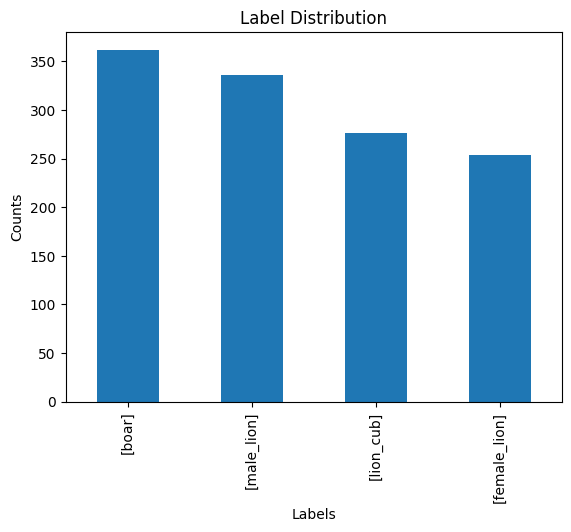

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming first_labels_df is your DataFrame and 'labels' is the column with labels
label_counts = first_labels_df['labels'].str.split(' ').value_counts()

# Create a bar plot
label_counts.plot(kind='bar')

# Setting the title and labels
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')

# Display the plot
plt.show()


In [7]:
parent_folder

PosixPath('/gdrive/MyDrive/image_dataset_curation_workshop_3')

https://docs.fast.ai/tutorial.vision.html#multi-label-classification---using-the-high-level-api

In [8]:
from fastai.vision.all import *

In [9]:
dls = ImageDataLoaders.from_df(first_labels_df, path='/',
                               label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224),
                               bs=16)

 Let's analyze our setup:

 **`item_tfms` and `batch_tfms`**:
   - We've set an `item_tfms` of `Resize(460)`, which means each item (image) will be resized to 460x460 pixels before batching.
   - The `batch_tfms` uses `aug_transforms(size=224)`, which indicates that after batching, the images will be augmented and resized to 224x224 pixels.



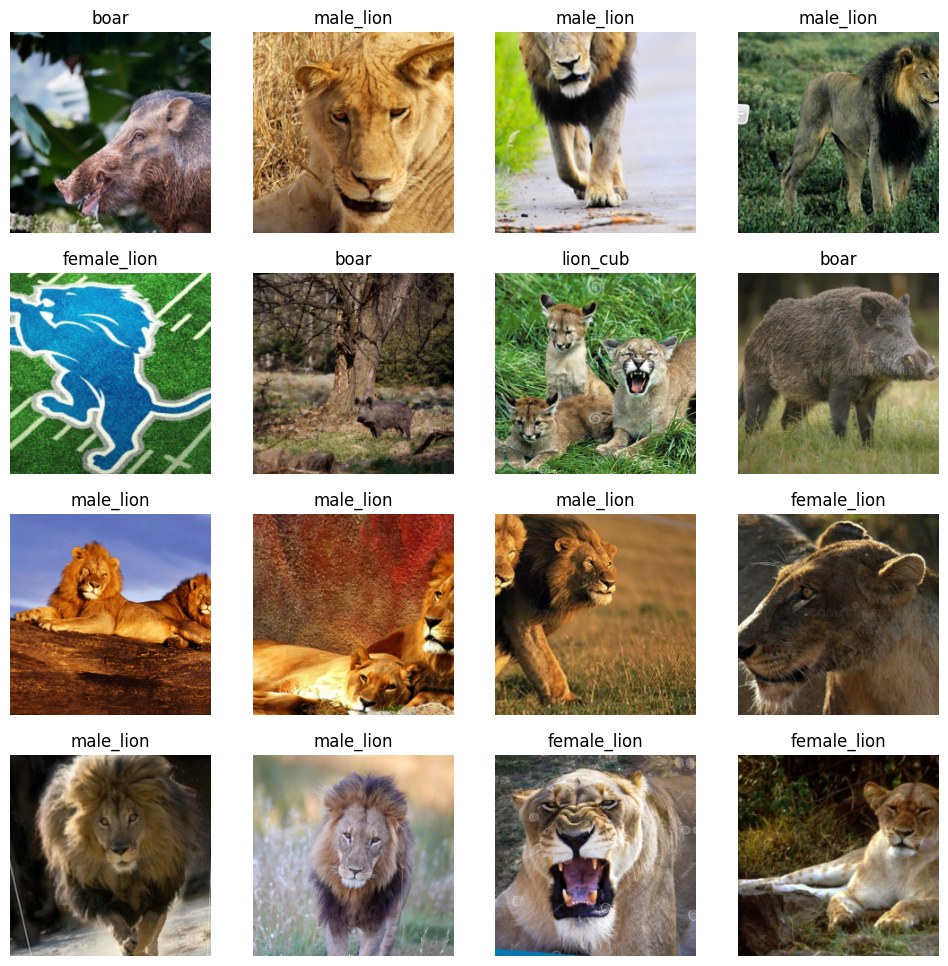

In [10]:
# Let's inspect a batch of training data and the augmentations that it has received
dls.train.show_batch(max_n=16, figsize=(12,12))

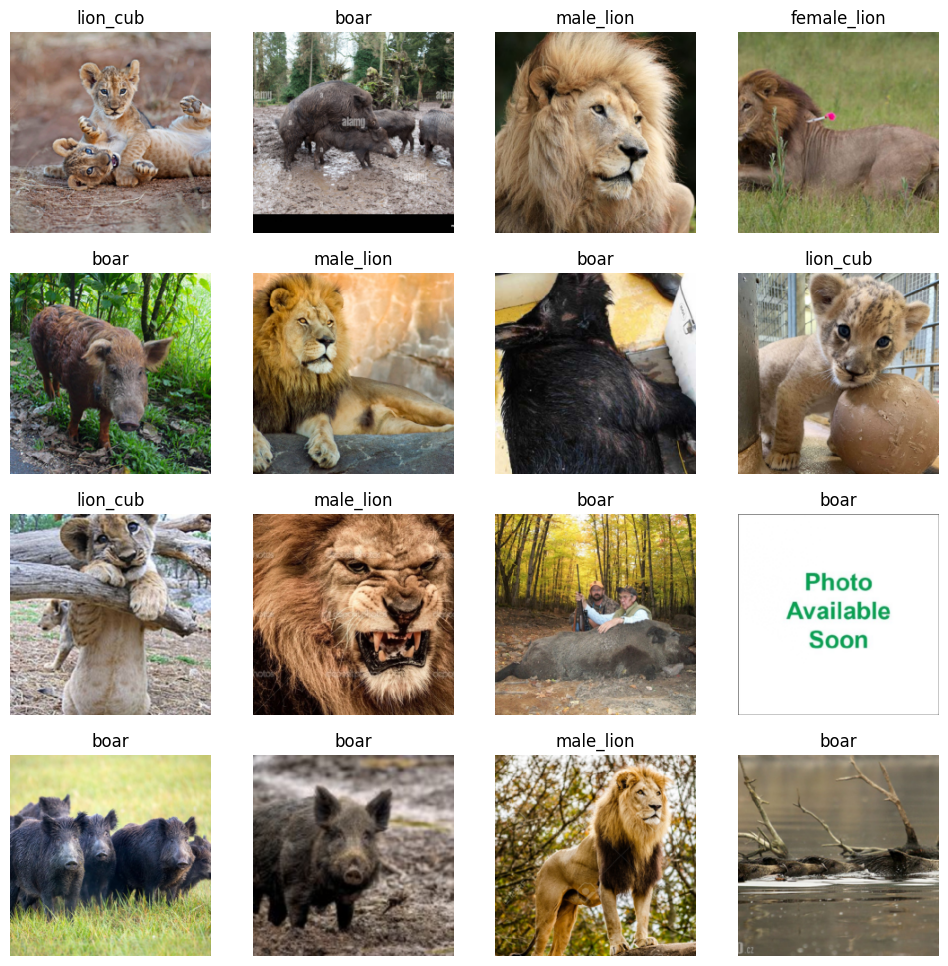

In [11]:
# The validation data is only center-cropped
dls.valid.show_batch(max_n=16, nrows=4)


In [12]:
# This lists all the unique classes in our dataset
print(dls.vocab)

['boar', 'female_lion', 'lion_cub', 'male_lion']


In [13]:
# dls.c gives the total number of classes
# dls.n gives the total number of images
dls.c, dls.n

(4, 983)

In [14]:
dls.after_item


Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor

In [15]:
dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}

In [16]:
# x is the batch of images
# y are the corresponding labels
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 4]))

In [17]:
# size of the batch of images used for stochastic gradient descent
dls.bs

16

In [18]:
dls.train_ds[0][0].shape

(480, 600)

In [19]:
dls.valid_ds[0][0].shape

(1200, 1920)

In [20]:
#https://forums.fast.ai/t/assertionerror-while-fine-tune/98676
# be careful to use accuracy_multi when doing multi-label classification
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'


## Understanding Resnets


Residual Networks, or ResNets, are a type of convolutional neural network (CNN) architecture that were designed to enable the training of very deep networks. They introduce a novel concept called "skip connections" or "residual connections". These connections allow the input of a layer to be added to the output of a layer a few hops ahead.


This architecture solves the problem of vanishing gradients, a common issue in deep networks where the gradient becomes too small for effective training as it propagates back through the layers. By using skip connections, ResNets allow for the training of networks that are much deeper than was previously feasible, leading to significant improvements in performance.

ResNets have become a standard architecture for many computer vision tasks due to their effectiveness and simplicity. They are particularly popular for tasks like image classification, object detection, and more.

We will retrain a Resnet, as shown in the diagram below. For this we will replace its final layers. FastAI will automatically replace the final thousand output units with four output units, as our classification problem has four classes.

![](https://github.com/andandandand/images-for-colab-notebooks/blob/main/Screenshot%202024-02-19%20at%2014.03.43.png?raw=true)

In [48]:
# This creates a pretrained Resnet and connects the data loaders and performance metrics that we have defined to it
learn = vision_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

In [22]:
# Inspect the model's architecture. How many units are in the last layer? Why?
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

SuggestedLRs(valley=0.002511886414140463)

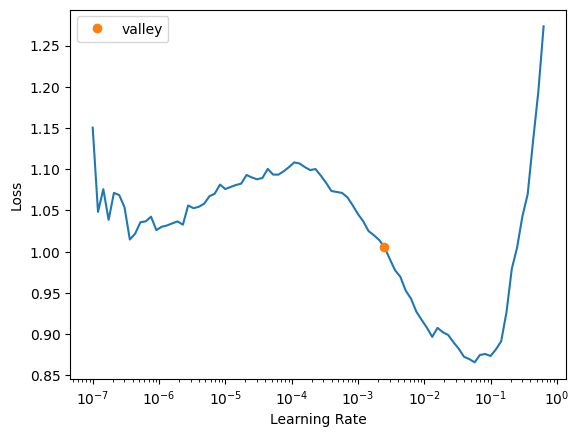

In [23]:
# the learning rate finder tries different learning rates on different batches of data
# this heuristic is just a suggestion for the initial learning rate
suggested_lr = learn.lr_find()
suggested_lr

In [24]:
# We want to save the model with the best validation loss
from fastai.callback.tracker import SaveModelCallback
# Add the SaveModelCallback
learn.add_cb(SaveModelCallback(monitor='valid_loss', fname='best_model', comp=None, min_delta=0.0))



In this setup:
- `monitor='valid_loss'` specifies that the callback should monitor the validation loss.
- `fname='best_model'` is the filename for the saved model.
- `comp` and `min_delta` are additional optional parameters. `comp` is a function that defines how to compare the monitored values (useful for metrics where 'less' is not better, like accuracy). `min_delta` specifies the minimum change in the monitored value to qualify as an improvement.


In [25]:
learn.fine_tune(3, suggested_lr[0])

Better model found at epoch 0 with valid_loss value: 0.4119386076927185.


Better model found at epoch 0 with valid_loss value: 0.32968732714653015.
Better model found at epoch 1 with valid_loss value: 0.2795233726501465.
Better model found at epoch 2 with valid_loss value: 0.2632913291454315.


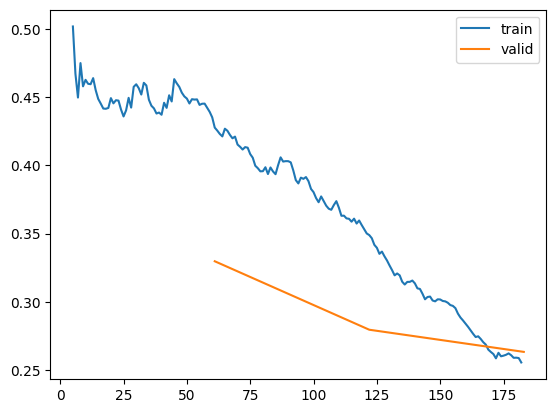

In [26]:
learn.recorder.plot_loss()

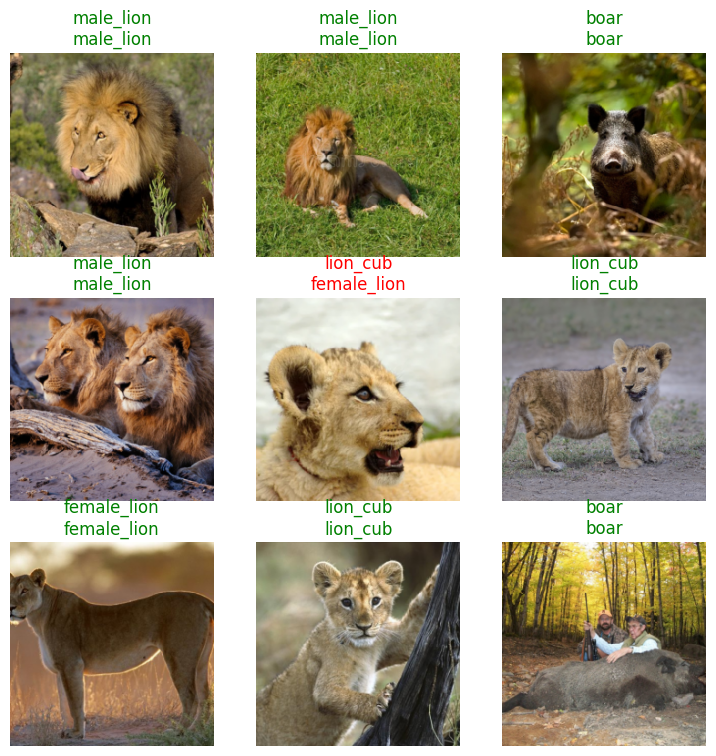

In [27]:
learn.show_results()

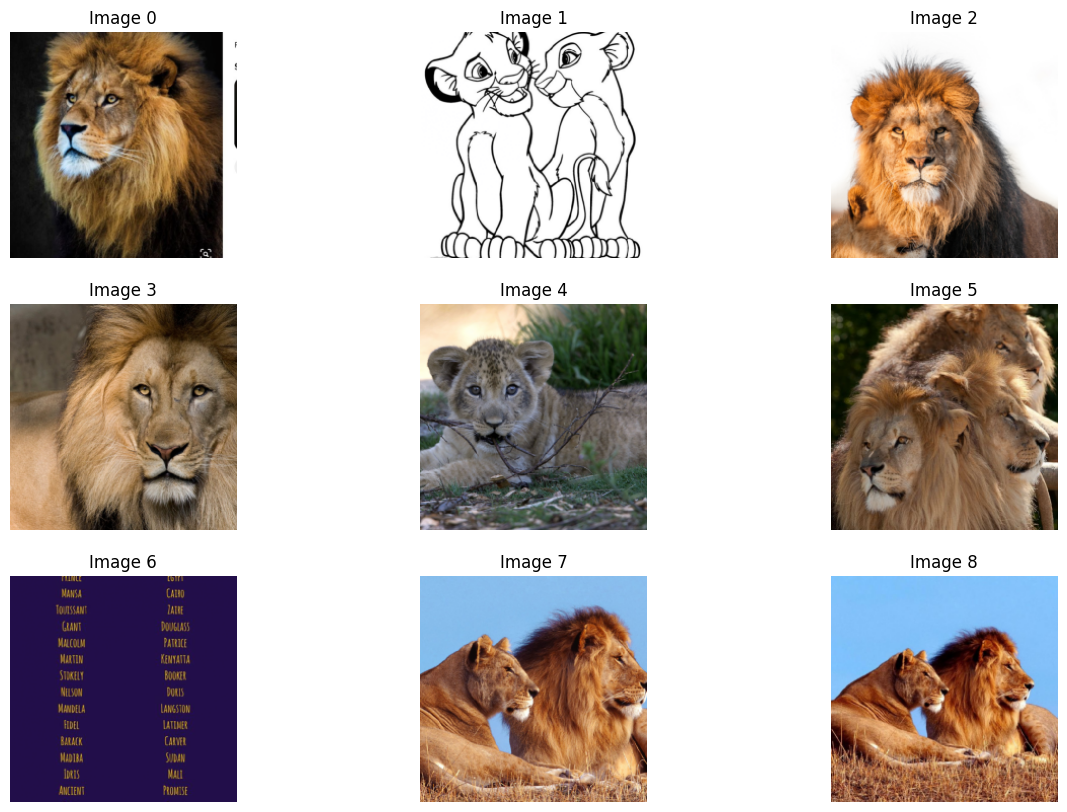

In [28]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))



## Lion or boar?

Some people believe that a [lion was let loose in Berlin last year](https://www.bbc.com/news/world-europe-66265874). Maybe it was a prank from that  Remmo guy.  There are [23 privately owned and registered lions in Brandenburg](https://www.tagesspiegel.de/berlin/23-lowen-in-brandenburg-gemeldet-haltung-von-grosskatzen--das-ist-die-rechtslage-in-berlin-und-der-region-10185343.html). Who knows. 🤔

Let's see what the neural network will output.


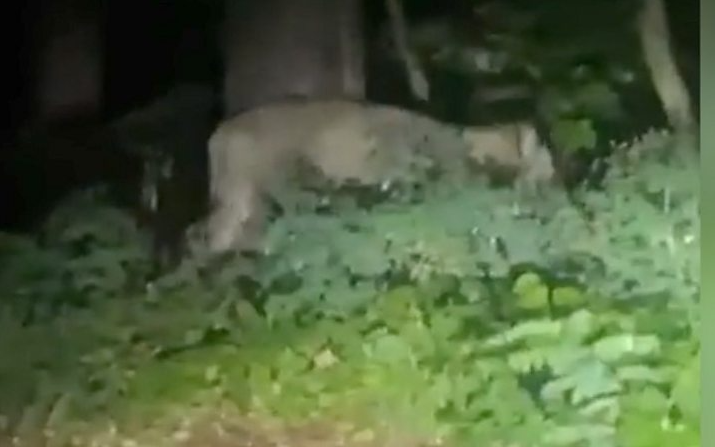

In [32]:
import skimage.io as io
test_image = Image.fromarray(io.imread('https://raw.githubusercontent.com/andandandand/images-for-colab-notebooks/main/Screenshot%202024-02-13%20at%2011.44.27.png')).convert('RGB')
test_image

In [33]:
test_image.save(parent_folder / 'test_images' / 'test_image.jpg')

In [34]:
test_images = get_image_files(parent_folder / 'test_images')
test_images

(#1) [Path('/gdrive/MyDrive/image_dataset_curation_workshop_3/test_images/test_image.jpg')]

In [35]:
# use image from the news
# the prediction is going to be empty if the threshold of activation is below what we set
# when we created the learner object
prediction = learn.predict(test_images[0])
prediction

((#2) ['boar','male_lion'],
 tensor([ True, False, False,  True]),
 tensor([0.5311, 0.0972, 0.1208, 0.6683]))

In [36]:
label_names = learn.dls.vocab
print(label_names)

['boar', 'female_lion', 'lion_cub', 'male_lion']


## Exploring Class Activation Mapping (CAM)

[CAM](https://arxiv.org/pdf/1512.04150.pdf) uses the output of the last convolutional layer and the predictions to create a heatmap of the visual features. It helps us understand why the model arrived to a decision.

![](https://github.com/andandandand/images-for-colab-notebooks/blob/main/Screenshot%202024-02-19%20at%2005.08.27.png?raw=true)

The dot product of the activations on the final convolutional layers after Global Average Pooling (GAP) with the last linear layer creates this localized heatmap.

In PyTorch, implementing Global Average Pooling can be done using `nn.AdaptiveAvgPool2D((1,1 ))` before a fully connected layer, as shown in the code example below:

```python
import torch
import torch.nn as nn

class ModelWithGAP(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelWithGAP, self).__init__()
        # Example convolutional layers (can be adjusted as needed)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer for classification
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Example model instantiation
model = ModelWithGAP(num_classes=10)


```

This coding part is more advanced and depends on the use of PyTorch hooks. Please refer to [chapter 18 of the FastAI book for reference](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb).

In [37]:
# "For CAM we want to store the activations of the last convolutional layer.
#  We put our hook function in a class so it has a state that we can access later, and just store a copy of the output:"
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

# We can then instantiate a Hook and attach it to the layer we want, which is the last layer of the CNN body:
hook_output = Hook()
hook_output


In [38]:
# the model is at learn.model[0]
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [39]:
hook = learn.model[0].register_forward_hook(hook_output.hook_func)
hook

In [40]:
# feed the image through the model
with torch.no_grad(): output = learn.model.eval()(x)

In [41]:
# access our stored activations
act = hook_output.stored[0]


In [42]:
# matrix multiplication using einstein summation, between the weights and the activation
# https://pytorch.org/docs/stable/generated/torch.einsum.html
# check the dimensions of both parts
print(learn.model[1][-1].weight.shape, act.shape)
# using 'ck,kij->cij' which values are c,k,i, and j?
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([4, 512]) torch.Size([512, 7, 7])


torch.Size([4, 7, 7])

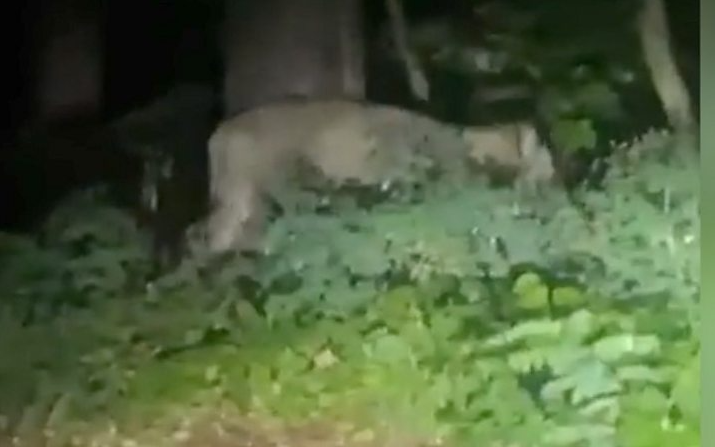

In [44]:
from fastai.vision.all import PILImage, TensorImage

img = PILImage.create(test_image)
img


In [45]:
# we put the image in a batch of the testing (not validation) set
x, = first(dls.test_dl([img]))
x.shape

torch.Size([1, 3, 224, 224])

## What is being highlighted in the activation map?

How does this relate to the training data?

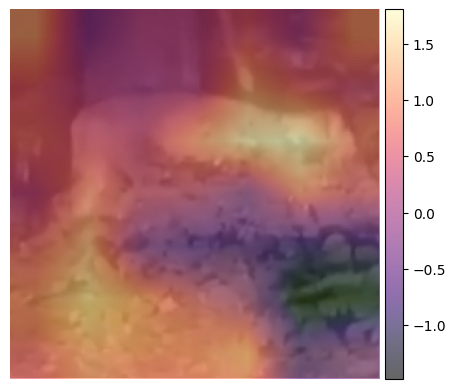

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Visualizing the image as if it were encoded in the validation set
# This will apply the centercrop transformation
x_dec = TensorImage(dls.valid.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
# we need to apply bilinear interpolation to plot the 7, 7 image obtained
# with average pooling as 224, 224 image
im = ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

# added colorbar
# https://matplotlib.org/3.1.1/gallery/axes_grid1/simple_colorbar.html#sphx-glr-gallery-axes-grid1-simple-colorbar-py
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax);